In [1]:
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\jayaw\AppData\Local\sagemaker\sagemaker\config.yaml


In [2]:
load_dotenv()

True

In [3]:
sm_boto3 = boto3.client("sagemaker")   # Create a low-level SageMaker client using boto3
sess = sagemaker.Session()             # Create a SageMaker session using the high-level SageMaker SDK
region = sess.boto_session.region_name # Get the AWS region associated with the current session
bucket = "student-sleep-quality-prediction-bucket-sagemaker"  # Define the name of your S3 bucket
print("Using bucket", bucket)          # Output the name of the bucket being used

Using bucket student-sleep-quality-prediction-bucket-sagemaker


## Load Dataset

In [4]:
df = pd.read_csv('student_sleep_patterns.csv')
df.head()

,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
0,1,24,Other,2nd Year,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,Male,1st Year,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,Male,4th Year,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,Other,4th Year,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,Male,4th Year,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01


## Exploratory Data Analysis (EDA)

In [5]:
df.shape

(500, 14)

In [6]:
df.isnull().sum()

Student_ID             0
Age                    0
Gender                 0
University_Year        0
Sleep_Duration         0
Study_Hours            0
Screen_Time            0
Caffeine_Intake        0
Physical_Activity      0
Sleep_Quality          0
Weekday_Sleep_Start    0
Weekend_Sleep_Start    0
Weekday_Sleep_End      0
Weekend_Sleep_End      0
dtype: int64

In [7]:
df['Sleep_Quality'].value_counts()

Sleep_Quality
1     66
6     57
9     55
3     54
10    50
2     46
4     46
7     45
5     41
8     40
Name: count, dtype: int64

Text(0, 0.5, 'Count')

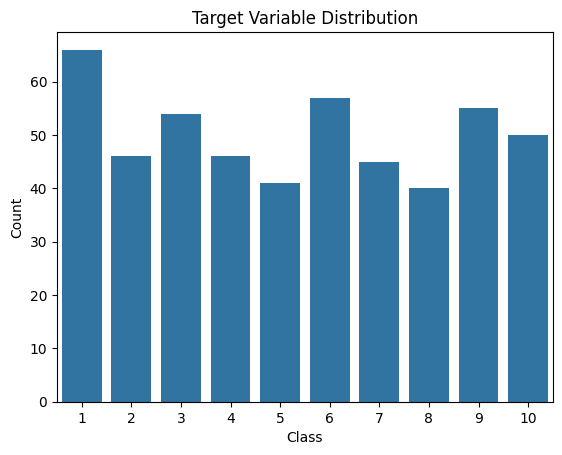

In [8]:
sns.countplot(x='Sleep_Quality', data=df)
plt.title("Target Variable Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

In [9]:
df.columns

Index(['Student_ID', 'Age', 'Gender', 'University_Year', 'Sleep_Duration',
       'Study_Hours', 'Screen_Time', 'Caffeine_Intake', 'Physical_Activity',
       'Sleep_Quality', 'Weekday_Sleep_Start', 'Weekend_Sleep_Start',
       'Weekday_Sleep_End', 'Weekend_Sleep_End'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Student_ID           500 non-null    int64  
 1   Age                  500 non-null    int64  
 2   Gender               500 non-null    object 
 3   University_Year      500 non-null    object 
 4   Sleep_Duration       500 non-null    float64
 5   Study_Hours          500 non-null    float64
 6   Screen_Time          500 non-null    float64
 7   Caffeine_Intake      500 non-null    int64  
 8   Physical_Activity    500 non-null    int64  
 9   Sleep_Quality        500 non-null    int64  
 10  Weekday_Sleep_Start  500 non-null    float64
 11  Weekend_Sleep_Start  500 non-null    float64
 12  Weekday_Sleep_End    500 non-null    float64
 13  Weekend_Sleep_End    500 non-null    float64
dtypes: float64(7), int64(5), object(2)
memory usage: 54.8+ KB


## Data Preprocessing

In [11]:
df.drop('Student_ID', inplace=True, axis=1)

In [12]:
TARGET = "Sleep_Quality"

In [13]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Apply LabelEncoder to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [14]:
X = df.drop(columns=[TARGET])  # Features (all except target)
y = df[TARGET]                 # Target variable

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

In [16]:
[print(f"{a.shape} \n") for a in (X_train, y_train, X_test, y_test)]

(425, 12) 

(425,) 

(75, 12) 

(75,) 



[None, None, None, None]

In [17]:
train_df = pd.DataFrame(X_train)
train_df[TARGET] = y_train

test_df = pd.DataFrame(X_test)
test_df[TARGET] = y_test

In [18]:
train_df.to_csv("train-V1.csv", index=False)
test_df.to_csv("test-V1.csv", index=False)

In [19]:
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = os.getenv('AWS_DEFAULT_REGION')

In [20]:
## send data to S3. Sagemaker will take the data for trainign from s3
sk_prefix="sagemaker/student-sleep-quality/sklearncontainer"
trainpath=sess.upload_data(path='train-V1.csv',bucket=bucket,key_prefix=sk_prefix)
testpath=sess.upload_data(path='test-V1.csv',bucket=bucket,key_prefix=sk_prefix)

print(trainpath)
print(testpath)

s3://student-sleep-quality-prediction-bucket-sagemaker/sagemaker/student-sleep-quality/sklearncontainer/train-V1.csv
s3://student-sleep-quality-prediction-bucket-sagemaker/sagemaker/student-sleep-quality/sklearncontainer/test-V1.csv


## Training in Sagemaker

In [21]:
%%writefile script.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score
import sklearn
import joblib
import boto3
import pathlib
from io import StringIO
import argparse
import os
import numpy as np
import pandas as pd


def model_fn(model_dir):
    clf=joblib.load(os.path.join(model_dir,"model.joblib"))

if __name__=="__main__":

    print("[Info] Extracting arguments")
    parser=argparse.ArgumentParser()

    ## Hyperparameter
    parser.add_argument("--n_estimators",type=int,default=100)
    parser.add_argument("--random_state",type=int,default=0)

    ### Data,model,and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train-V1.csv")
    parser.add_argument("--test-file", type=str, default="test-V1.csv")

    args, _ =parser.parse_known_args()

    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("[INFO] Reading data")
    print()
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    features = list(train_df.columns)
    label = features.pop(-1)

    print("Building training and testing datasets")
    print()
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    print('Column order: ')
    print(features)
    print()
    print("Label column is: ",label)
    print()
    print("Data Shape: ")
    print()
    print("---- SHAPE OF TRAINING DATA (85%) ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA (15%) ----")
    print(X_test.shape)
    print(y_test.shape)
    print()


    print("Training RandomForest Model ....")
    print()
    model=RandomForestClassifier(n_estimators=args.n_estimators,random_state=args.random_state, verbose=2,n_jobs=1)
    model.fit(X_train,y_train)

    print()

    model_path=os.path.join(args.model_dir,"model.joblib")
    joblib.dump(model,model_path)

    print("Model saved at" + model_path)

    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test,y_pred_test)
    test_rep = classification_report(y_test,y_pred_test)

    print()
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ')
    print(test_rep)




Writing script.py


## AWS Sagemaker Entrypoint to Execute Training Script

In [ ]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION="0.23-1"

sklearn_estimator=SKLearn(
    entry_point="script.py",
    role="arn:aws:iam::703671911782:role/sagemakeraccess",
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="RF-custom-sklearn",
    hyperparameters={
        "n_estimators":100,
        "random_state":0
    },
    use_spot_instance=True,
    max_run=3600

)

'''
The script begins by importing SKLearn from the sagemaker.sklearn.estimator module. This class is used to define and configure Scikit-learn training jobs to run on SageMaker's managed infrastructure. 
The FRAMEWORK_VERSION variable is set to "0.23-1", specifying the version of the Scikit-learn framework to be used in the training environment provided by SageMaker.
The sklearn_estimator object is then created as an instance of SKLearn. The key argument here is entry_point="script.py",
which refers to a local Python script that contains the training logic — it must include a train() function that SageMaker will execute. The role parameter provides the Amazon Resource Name (ARN) of an IAM role that grants SageMaker permission to access AWS resources like S3 buckets and logging services. 
The training job is configured to use a single instance (instance_count=1) of type ml.m5.large, which offers a balance of CPU and memory resources suitable for many medium-sized ML tasks.
The base_job_name is set to "RF-custom-sklearn", which SageMaker will use as a prefix for the training job name. The hyperparameters dictionary includes two entries: n_estimators=100 and random_state=0, likely for configuring a Random Forest model within the script.py training script. These hyperparameters will be passed into your script at runtime via command-line arguments. 
Finally, the script enables cost-efficient spot instances using use_spot_instance=True, and sets a maximum run time of 3600 seconds (1 hour) using max_run=3600, ensuring the training job does not run indefinitely.'''

In [23]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: RF-custom-sklearn-2025-06-25-06-51-01-349


2025-06-25 06:51:11 Starting - Starting the training job...
2025-06-25 06:51:45 Downloading - Downloading input data...
2025-06-25 06:52:10 Downloading - Downloading the training image.....2025-06-25 06:53:00,493 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-06-25 06:53:00,497 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-25 06:53:00,540 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-06-25 06:53:00,692 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-25 06:53:00,704 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-25 06:53:00,719 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-25 06:53:00,728 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
    

## Load the Model from S3 Bucket

In [ ]:
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

'''
This code block is used to monitor and retrieve the output of a completed SageMaker training job initiated using the sklearn_estimator.
The first line, sklearn_estimator.latest_training_job.wait(logs="None"), waits for the most recent training job to finish.
Setting logs="None" means it won’t stream the logs to the notebook — the code simply pauses until the job is done.
Once the job completes, the next line uses boto3 (specifically the low-level sagemaker client) to call describe_training_job, passing the name of the training job.
This returns metadata about the job, from which the code extracts the S3 URI of the model artifacts — the trained model and any files output by the training script.
The resulting artifact variable holds the S3 path to the trained model, which is necessary for model deployment or further processing.'''


2025-06-25 06:53:19 Starting - Preparing the instances for training
2025-06-25 06:53:19 Downloading - Downloading the training image
2025-06-25 06:53:19 Training - Training image download completed. Training in progress.
2025-06-25 06:53:19 Uploading - Uploading generated training model
2025-06-25 06:53:19 Completed - Training job completed


In [25]:
artifact

's3://sagemaker-us-east-1-703671911782/RF-custom-sklearn-2025-06-25-06-51-01-349/output/model.tar.gz'

## Deploy the Model to get the Endpoint

In [ ]:
from sagemaker.sklearn.model import SKLearnModel
from time import gmtime,strftime


model_name="Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model=SKLearnModel(
    name=model_name,
    model_data=artifact,
    role="arn:aws:iam::703671911782:role/sagemakeraccess",
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION
)

'''
It begins by generating a unique name for the model using the current timestamp, resulting in a name like "Custom-sklearn-model-2025-06-21-10-30-00".
This helps distinguish models by their creation time. Then, an instance of SKLearnModel is created, which represents the trained Scikit-learn model and its deployment configuration.

The model_data parameter is set to the artifact — the S3 URI where the trained model artifacts were stored by the SageMaker training job.
The role parameter provides the IAM role ARN that SageMaker will assume to load the model and perform inference.
The entry_point="script.py" specifies the Python script that includes the necessary functions (model_fn, input_fn, predict_fn, output_fn) to load and run the model in a production environment.
Lastly, framework_version=FRAMEWORK_VERSION ensures the correct Scikit-learn runtime environment (like "0.23-1") is used to match the training configuration.'''

In [30]:
model

In [ ]:
## Endpoint deployment
endpoint_name="Custom-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

predictor=model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name
)

'''
First, it creates a unique endpoint_name using a timestamp (e.g., "Custom-sklearn-model-2025-06-21-10-45-00")
to avoid naming conflicts and help trace deployments over time.
This name is printed for reference, as you’ll need it when sending prediction requests or managing the endpoint later.
Then, model.deploy() is called, which launches a SageMaker endpoint with:
    - initial_instance_count=1: using one inference instance,
    - instance_type="ml.m4.xlarge": a general-purpose compute instance,
    - endpoint_name: assigning it the custom name generated above.
The result, predictor, is an object you can use directly in Python to send prediction inputs to the deployed model using .predict().'''

EndpointName=Custom-sklearn-model-2025-06-25-07-37-03


INFO:sagemaker:Creating model with name: Custom-sklearn-model-2025-06-25-07-37-00
INFO:sagemaker:Creating endpoint-config with name Custom-sklearn-model-2025-06-25-07-37-03
INFO:sagemaker:Creating endpoint with name Custom-sklearn-model-2025-06-25-07-37-03


--------!

In [32]:
predictor

In [33]:
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '65549a8d-29a1-4a9d-b3b3-cacee6beefbd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '65549a8d-29a1-4a9d-b3b3-cacee6beefbd',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 25 Jun 2025 07:41:52 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}